## Import Fast.AI

In [5]:
from fastai.vision import *

In [6]:
classes = ['benign','melanoma']

## View data

In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder('data/melanoma', train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [8]:
data.classes

['Benign', 'Melanoma']

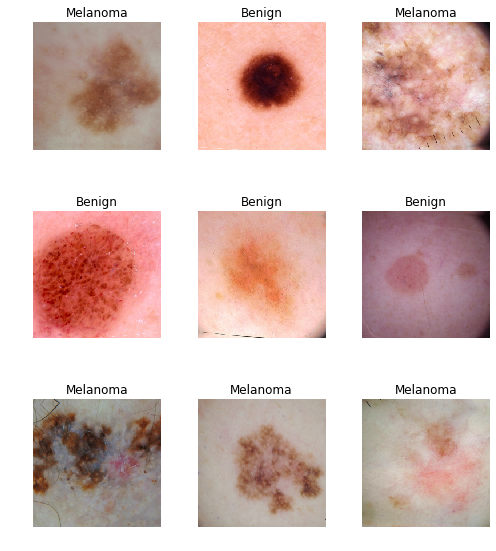

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Benign', 'Melanoma'], 2, 780, 194)

## Train model

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

In [13]:
learn.save('stage-1')

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


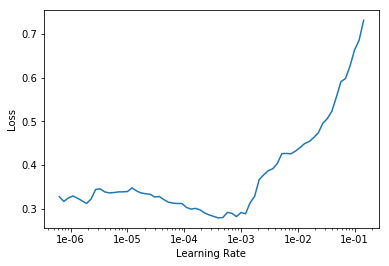

In [16]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-4))

In [18]:
learn.save('stage-2')

## Interpretation

In [19]:
learn.load('stage-2');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

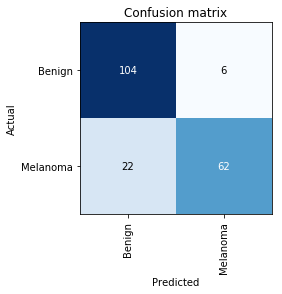

In [21]:
interp.plot_confusion_matrix()

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [22]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [23]:
defaults.device = torch.device('cpu')

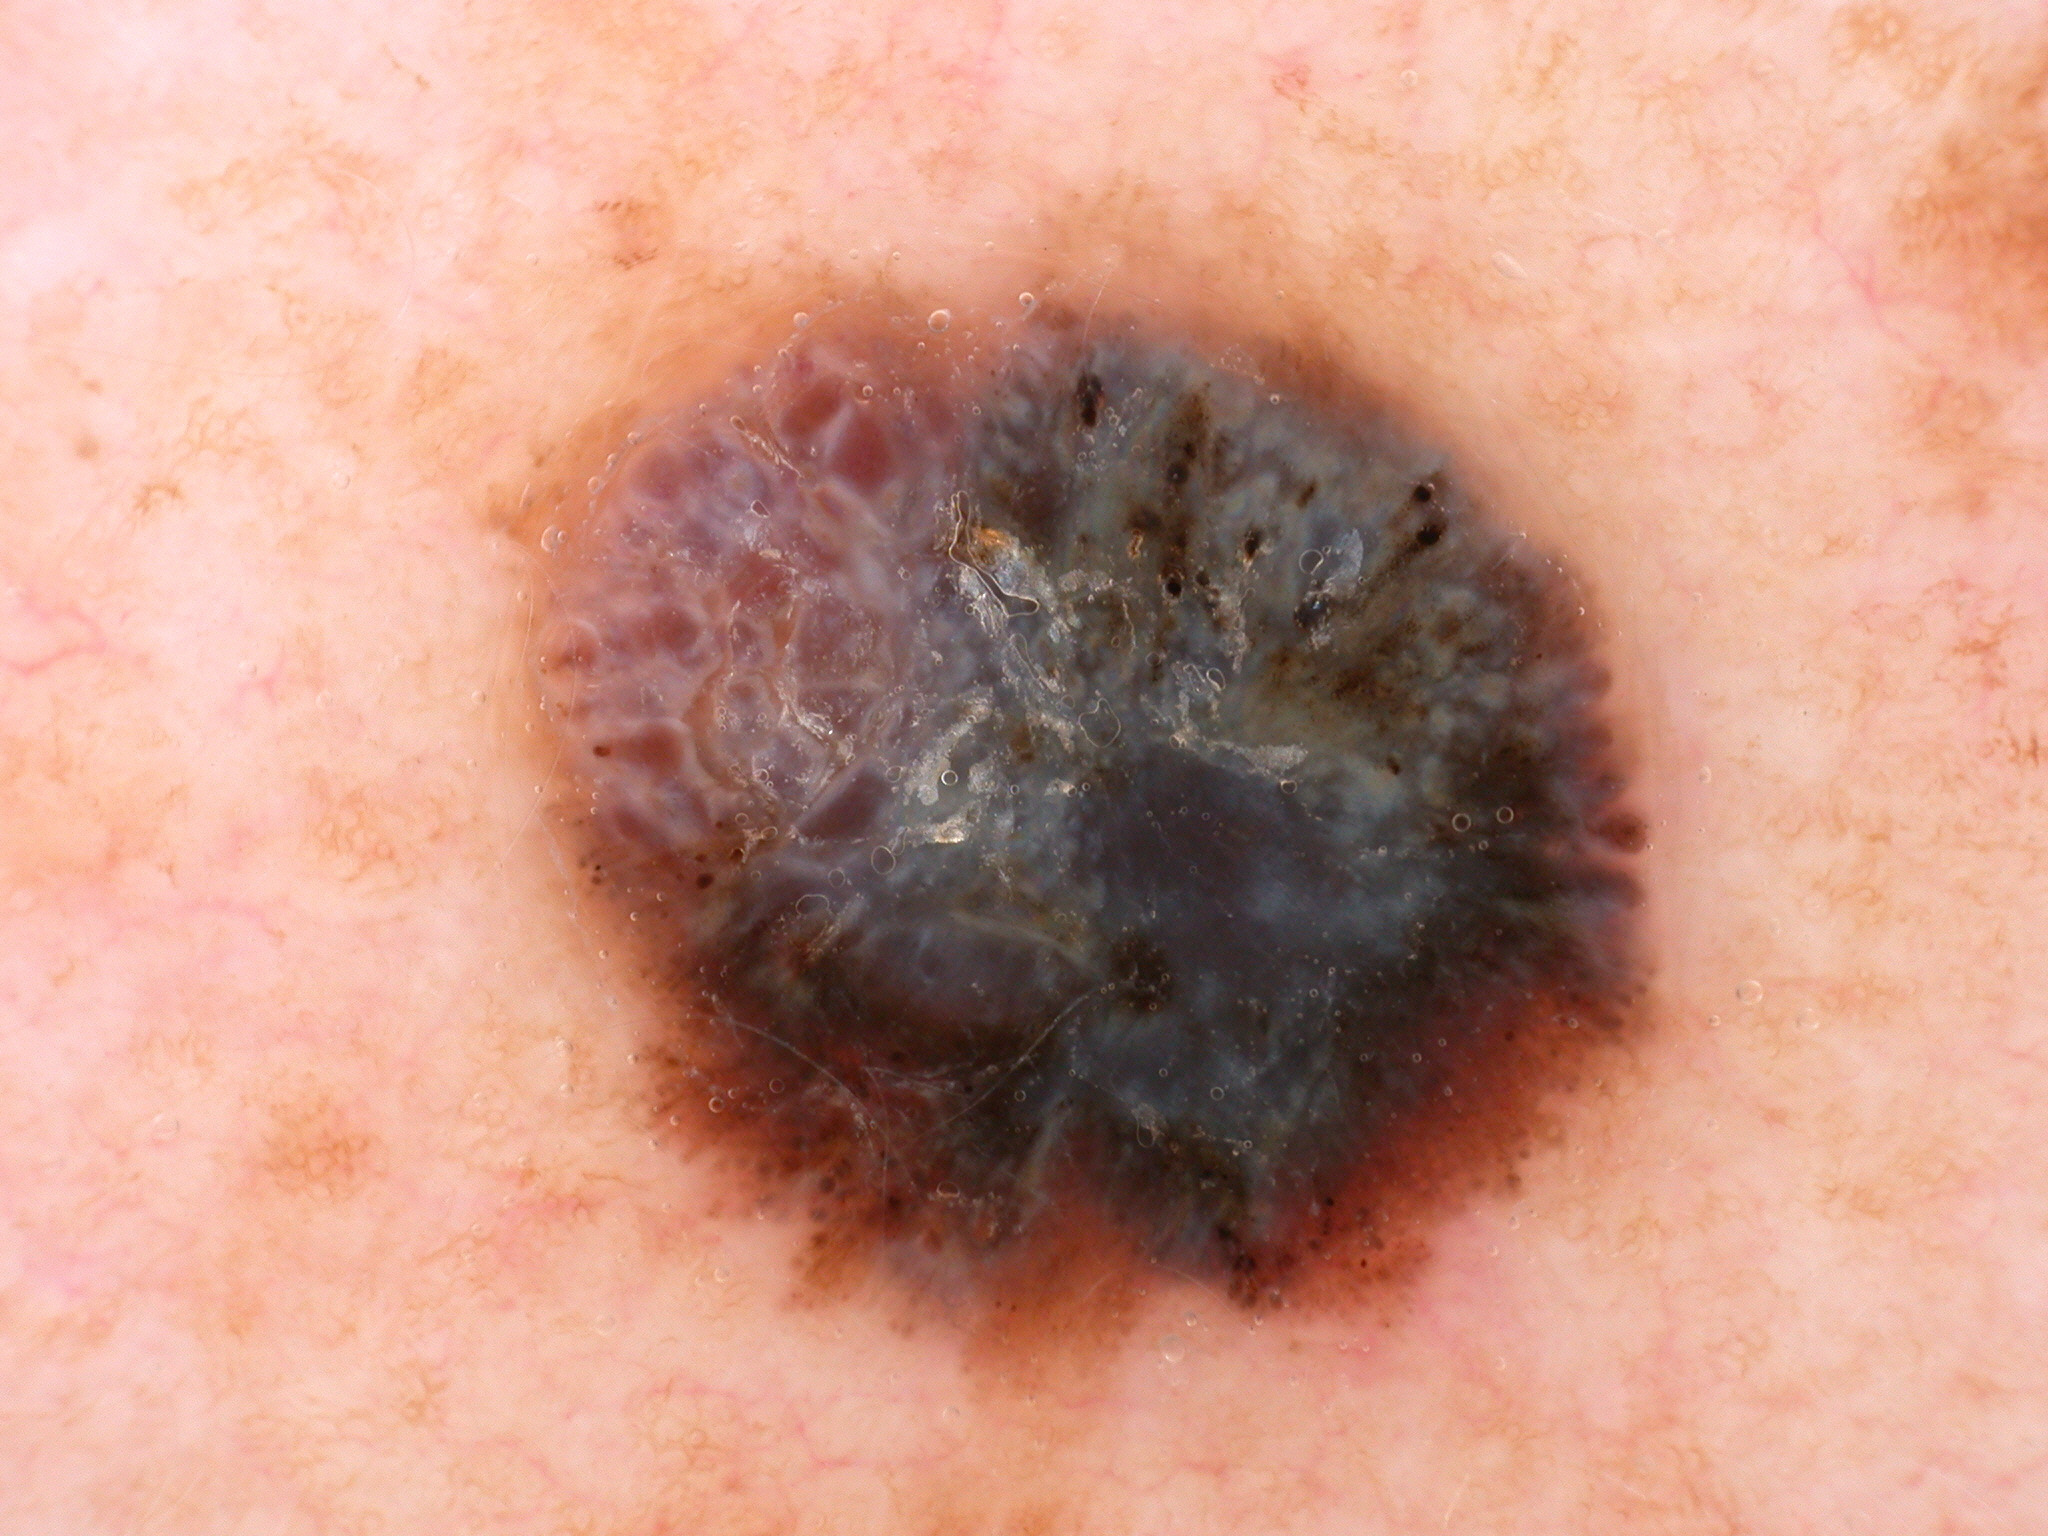

In [24]:
img = open_image('data/melanoma/Melanoma/ISIC_0000142.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [25]:
learn = load_learner('data/melanoma')

In [26]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category tensor(1)

In [27]:
data.classes

['Benign', 'Melanoma']

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)